In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [4]:
# --- 2. Parameters ---
vocab_size = 10000  # Keep the top 10,000 most frequent words
maxlen = 250        # Pad/truncate reviews to this length
embedding_dim = 16
dense_units = 16
epochs = 10
batch_size = 512

In [5]:
print("\n--- Loading IMDB dataset ---")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
print(f"Training sequences: {len(x_train)}, Test sequences: {len(x_test)}")
print(f"Training labels: {len(y_train)}, Test labels: {len(y_test)}")


--- Loading IMDB dataset ---
Training sequences: 25000, Test sequences: 25000
Training labels: 25000, Test labels: 25000


In [6]:
print("\n--- Exploratory Data Analysis ---")
print("Sample review (sequence of word indices):")
print(x_train[0][:20], "...") # Show first 20 indices of the first review
print("Label for first review:", y_train[0], "(0: Negative, 1: Positive)")

# 4.2 Label Distribution
print("\nLabel Distribution:")
labels, counts = np.unique(y_train, return_counts=True)
print(f"Train set: Label 0: {counts[0]}, Label 1: {counts[1]}")
labels_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Test set:  Label 0: {counts_test[0]}, Label 1: {counts_test[1]}")


--- Exploratory Data Analysis ---
Sample review (sequence of word indices):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25] ...
Label for first review: 1 (0: Negative, 1: Positive)

Label Distribution:
Train set: Label 0: 12500, Label 1: 12500
Test set:  Label 0: 12500, Label 1: 12500


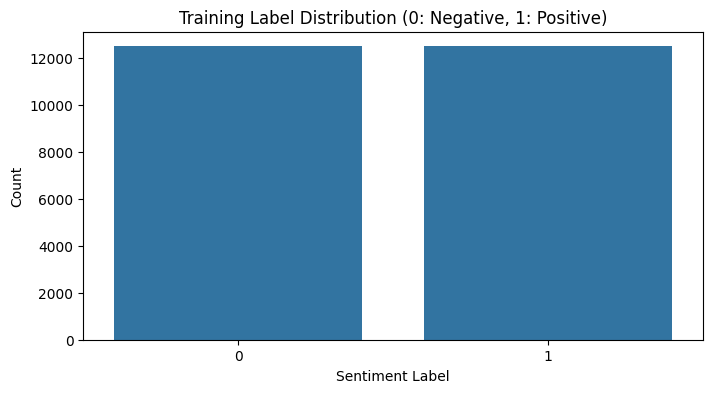

In [7]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.title('Training Label Distribution (0: Negative, 1: Positive)')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


Review Length Analysis:




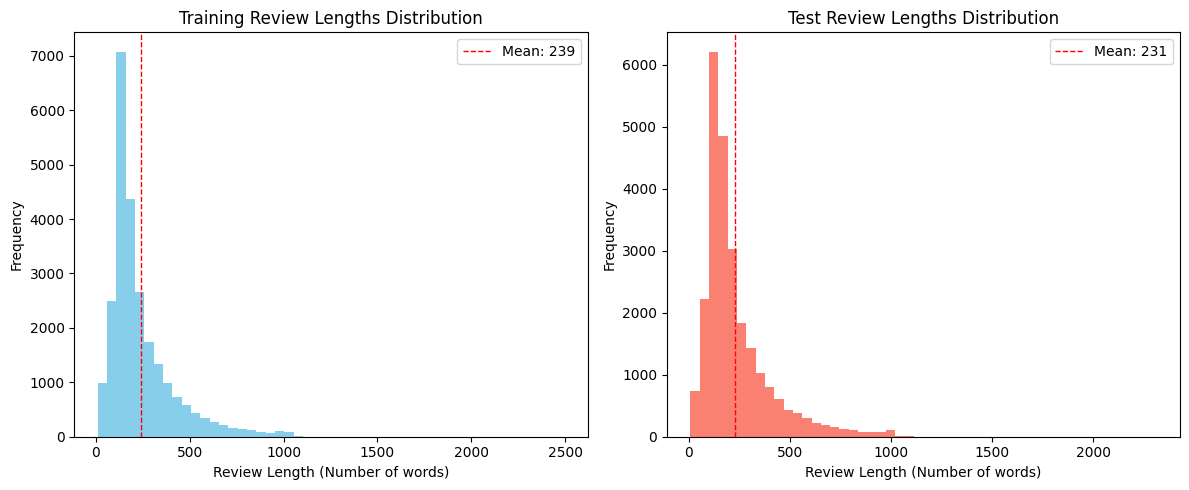

Average training review length: 238.71 words
Average test review length: 230.80 words
Max training review length: 2494 words
Max test review length: 2315 words


In [8]:
print("\nReview Length Analysis:\n\n")
train_lengths = [len(seq) for seq in x_train]
test_lengths = [len(seq) for seq in x_test]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, color='skyblue')
plt.title('Training Review Lengths Distribution')
plt.xlabel('Review Length (Number of words)')
plt.ylabel('Frequency')
plt.axvline(np.mean(train_lengths), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(train_lengths):.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test_lengths, bins=50, color='salmon')
plt.title('Test Review Lengths Distribution')
plt.xlabel('Review Length (Number of words)')
plt.ylabel('Frequency')
plt.axvline(np.mean(test_lengths), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(test_lengths):.0f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Average training review length: {np.mean(train_lengths):.2f} words")
print(f"Average test review length: {np.mean(test_lengths):.2f} words")
print(f"Max training review length: {np.max(train_lengths)} words")
print(f"Max test review length: {np.max(test_lengths)} words")

In [9]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note: Indices are offset by 3 because 0 (padding), 1 (start), 2 (unknown) are reserved.
def decode_review(text_indices):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text_indices])

In [10]:
print("\nDecoded first training review:\n\n")
print(decode_review(x_train[0]))


Decoded first training review:


? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

In [11]:
print(f"\n--- Preprocessing Data (Padding sequences to maxlen={maxlen}) ---")
x_train_pad = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

print("Shape of padded training data:", x_train_pad.shape)
print("Shape of padded test data:", x_test_pad.shape)
print("Example of padded sequence (first review):")
print(x_train_pad[0])


--- Preprocessing Data (Padding sequences to maxlen=250) ---
Shape of padded training data: (25000, 250)
Shape of padded test data: (25000, 250)
Example of padded sequence (first review):
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13

In [12]:
print("\n--- Building the DNN Model ---")
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Flatten(), # Flattens the 3D tensor (batch_size, maxlen, embedding_dim) to 2D (batch_size, maxlen * embedding_dim)
    Dense(dense_units, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])


--- Building the DNN Model ---


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
print("\n--- Training the Model ---")
history = model.fit(x_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test_pad, y_test),
                    verbose=1) 


--- Training the Model ---
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5309 - loss: 0.6905 - val_accuracy: 0.6779 - val_loss: 0.6398
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7747 - loss: 0.5241 - val_accuracy: 0.8411 - val_loss: 0.3657
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8831 - loss: 0.2905 - val_accuracy: 0.8514 - val_loss: 0.3356
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9233 - loss: 0.2098 - val_accuracy: 0.8581 - val_loss: 0.3269
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9448 - loss: 0.1638 - val_accuracy: 0.8580 - val_loss: 0.3329
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9747 - loss: 0.1063 - val_accuracy: 0.8570 - val_loss: 0.3437
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9829 - loss: 0.0805 - val_accuracy: 0.8434 - val_loss: 0.3881
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9916 - loss: 0.052

In [15]:
print("\n--- Evaluating the Model ---")
loss, accuracy = model.evaluate(x_test_pad, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


--- Evaluating the Model ---
Test Loss: 0.4249
Test Accuracy: 0.8496 (84.96%)



--- Visualizing Training History ---


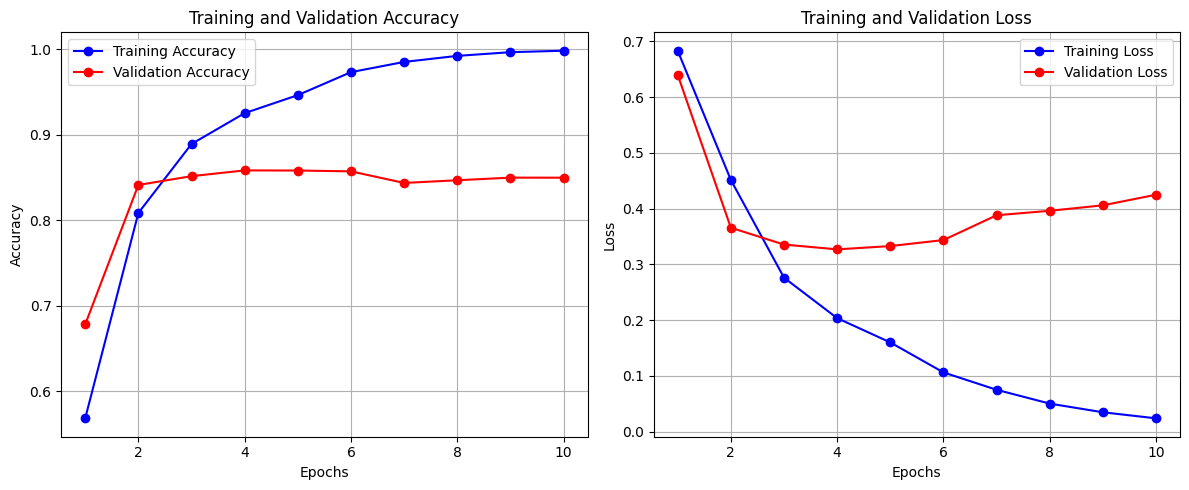

In [16]:
print("\n--- Visualizing Training History ---")
history_dict = history.history


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()